# **Inner Evaluation 3**

> **Finding the best model among XGBoost, Multi Layer Perceptron and two `PyTorch` Neural Networks for our classification task considering only the top 5 features extraction methods obtained in the previous inner evaluation round.**

## **Requirements**

In [2]:
import numpy  as np
import polars as pl
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from  xgboost import XGBClassifier
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, StratifiedKFold
from itertools import combinations
from skorch import NeuralNetClassifier
import torch

In [4]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyML_Package_Private')
from PyML.evaluation import SimpleEvaluation
from PyML.transformers import scaler

In [5]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyAudio_Package_Private')
from PyAudio import get_X_audio_features

In [ ]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyDL_Package_Private')
from PyDL.models import SimpleClassifier, AdvancedClassifier

In [6]:
advanced_NN = NeuralNetClassifier(
                module = AdvancedClassifier(input_dim=10, output_dim=2, 
                                            hidden_layers=[128, 256, 128], dropout_rate=0.3,
                                            random_state=123),
                criterion = torch.nn.CrossEntropyLoss,  # Use CrossEntropyLoss for multi-class classification
                optimizer = torch.optim.Adam,
                lr = 0.001,
                max_epochs = 100,
                batch_size = 64,
                verbose=False
)

In [7]:
simple_NN = NeuralNetClassifier(
                module = SimpleClassifier(input_dim=10, output_dim=2, 
                                          n_layers=3, random_state=123),
                criterion = torch.nn.CrossEntropyLoss,  # Use CrossEntropyLoss for multi-class classification
                optimizer = torch.optim.Adam,
                lr = 0.001,
                max_epochs = 100,
                batch_size = 64,
                verbose=False
)

In [8]:
with open(f'results/top_methods_2', 'rb') as file:
        top_methods = pickle.load(file)

with open(f'results/top_stats_2', 'rb') as file:
        top_stats = pickle.load(file)

## **Data definition**

In this section we define the data to be used. Specifically we define the response variable and a set of predictors matrices to be used as different alternatives, each one associate to a combination of features extraction methods and statistics.

In [8]:
files_list_name = 'Files_List.txt'
files_df = pl.read_csv(files_list_name, separator='\t', has_header=False, new_columns=['path', 'level'])

We define the parameters to be used by the features extraction methods.

In [9]:
fs = 16000 # Sampling frequency
wst = 0.032 # Window size (seconds)
fpt = 0.008 # Frame period (seconds)
nfft = int(np.ceil(wst*fs)) # Window size (samples)
fp = int(np.ceil(fpt*fs)) # Frame period (samples)
nbands = 40 # Number of filters in the filterbank
ncomp = 20 # Number of MFCC components

In the next cell we define the response variable (target) and the different predictors matrices mentioned above.

In [ ]:
Y = files_df['level'].to_numpy()

simple_methods = ['MFCC', 'spectral_centroid', 'chroma', 'spectral_bandwidth', 
                  'spectral_contrast', 'spectral_rolloff', 'zero_crossing_rate', 'tempogram']

combined_methods = []

stats = ['mean-std', 'median-std', 'mean-median-std', 'mean-Q25-median-Q75-std']

sizes = range(2, len(simple_methods) + 1)

combined_methods = ['-'.join(sorted(combi)) for size in sizes for combi in combinations(simple_methods, size)]

X_stats, X_stats_train, X_stats_test = {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}

for method in simple_methods:
    for stat in stats:

        X_stats[method][stat] = get_X_audio_features(paths=files_df['path'], method=method, stats=stat, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

for method in combined_methods:
    for stat in stats:

        X_stats[method][stat] = np.column_stack([X_stats[method.split('-')[i]][stat] for i in range(0, len(method.split('-')))])

## **Outer validation method: train-test split**

We split our data (response and predictors) in two partitions, the training and the testing one. The training partition will be used in the inner evaluation for selecting the best approach to predict the PD level, and the test one will only be used at the very end for making an estimation of the future performance of the best approach, that is, and estimation of how this approach will classify the level of PD of new patients.

In [ ]:
for method in simple_methods + combined_methods:
    for stat in stats:
        X_stats_train[method][stat], X_stats_test[method][stat], Y_train, Y_test = train_test_split(X_stats[method][stat], Y, test_size=0.25, random_state=123, stratify=Y)

- Converting to tensor to make the data type suitable for `PyTorch`

In [14]:
X_stats_pytorch, X_stats_train_pytorch, X_stats_test_pytorch = {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}

for size in combined_methods.keys():
    for method in combined_methods[size]:
        for stat in stats:
            X_stats_pytorch[method][stat] = torch.tensor(X_stats[method][stat], dtype=torch.float32)
            X_stats_train_pytorch[method][stat] = torch.tensor(X_stats_train[method][stat], dtype=torch.float32)
            X_stats_test_pytorch[method][stat] = torch.tensor(X_stats_test[method][stat], dtype=torch.float32)

Y_pytorch = torch.tensor(Y, dtype=torch.float32)
Y_train_pytorch = torch.tensor(Y_train, dtype=torch.float32)
Y_test_pytorch = torch.tensor(Y_test, dtype=torch.float32)

## **Applying Inner Evaluation**

In this section we are going to apply the round three of the inner evaluation.

### **Inner validation method: KFold Cross Validation**

We define the validation method to be used in the inner evaluation, that will be Stratified KFold Cross Validation.

In [15]:
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

We define dictionaries to save important results that will be gathered in the inner evaluation.

In [16]:
inner_score, best_params, inner_results = {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods_flatten}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods_flatten}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods_flatten}

### **Grids for HPO** 

In this part we define the grids for the models that will be evaluated. 

#### Grid for XGBoost

In [17]:
def param_grid_XGB(trial):

    param_grid = ({
        'max_depth': trial.suggest_categorical('max_depth', [None, 2, 4, 7, 10, 15, 20, 25, 35]),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1, log=True),
        'n_estimators': trial.suggest_categorical('n_estimators', [75, 100, 150, 200, 250, 300, 350]),
        'eta': trial.suggest_float('eta', 0.001, 0.3, log=True),
        'alpha': trial.suggest_float('alpha', 0.2, 1, log=True)
    })

    return param_grid

#### Grid for Multi Layer Perceptron

In [18]:
# Grid for Multi-Layer Perceptron
def param_grid_MLP(trial):

    param_grid = ({
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True),
        'alpha': trial.suggest_float('alpha', 0.001, 0.2, log=True),
        'activation': trial.suggest_categorical('activation', ['logistic']),
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [80, 100, 130, 150, 180, 200, 250, 300, 350, 400]),
        'max_iter': trial.suggest_categorical('max_iter', [100, 130, 150, 180, 200, 250, 300, 350, 400])
    })

    return param_grid

#### Grid for Advanced NN (PyTorch)

- Defining grid to be used with `Optuna`

In [19]:
def param_grid_Advanced_NN(trial, input_dim, output_dim):

    hidden_layers_choice = trial.suggest_categorical('module__hidden_layers', 
                                                     ['[120, 200]', '[100, 100, 100]',
                                                      '[250, 250, 250]', '[128, 256, 128]', 
                                                      '[128, 256, 128, 220]', '[128, 150, 128, 150]',
                                                      '[300, 150, 300, 150]',
                                                      '[128, 256, 128, 220, 200]'
                                                      ])

    param_grid = ({
        'module__input_dim': trial.suggest_categorical('module__input_dim', [input_dim]),
        'module__output_dim': trial.suggest_categorical('module__output_dim', [output_dim]),
        'module__hidden_layers': eval(hidden_layers_choice),
        'module__dropout_rate': trial.suggest_float('module__dropout_rate', 0.05, 0.6, log=True),
        'lr': trial.suggest_float('lr', 0.0001, 0.01, log=True),
        'max_epochs': trial.suggest_categorical('max_epochs', [75, 100, 130, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600])
    })

    return param_grid

- Defining grig to be used with `Sklearn` HPO modules

In [20]:
'''
param_grid_Advanced_NN = {}

for method, stat in zip(top_methods, top_stats):

    input_dim = X_stats_train[method][stat].shape[1]
    output_dim = len(np.unique(Y_train))

    param_grid_Advanced_NN[(input_dim, output_dim)] = {

            'module__input_dim':  [input_dim],
            'module__output_dim': [output_dim],
            'module__hidden_layers': [[128, 256, 128], [128, 256, 128, 220]],
            'module__dropout_rate': [0.3, 0.5],
            'lr': [0.001, 0.0001],
            'max_epochs':[50, 100]
        }
'''

"\nparam_grid_Advanced_NN = {}\n\nfor method, stat in zip(top_methods, top_stats):\n\n    input_dim = X_stats_train[method][stat].shape[1]\n    output_dim = len(np.unique(Y_train))\n\n    param_grid_Advanced_NN[(input_dim, output_dim)] = {\n\n            'module__input_dim':  [input_dim],\n            'module__output_dim': [output_dim],\n            'module__hidden_layers': [[128, 256, 128], [128, 256, 128, 220]],\n            'module__dropout_rate': [0.3, 0.5],\n            'lr': [0.001, 0.0001],\n            'max_epochs':[50, 100]\n        }\n"

#### Grid for Simple NN (PyTorch)

In [21]:
def param_grid_Simple_NN(trial, input_dim, output_dim):

    param_grid = ({
        'module__input_dim': trial.suggest_categorical('module__input_dim', [input_dim]),
        'module__output_dim': trial.suggest_categorical('module__output_dim', [output_dim]),
        'module__n_layers': trial.suggest_categorical('module__n_layers', [1, 2, 3, 4, 5, 7]),
        'lr': trial.suggest_float('lr', 0.0001, 0.01, log=True),
        'max_epochs': trial.suggest_categorical('max_epochs', [75, 100, 130, 150, 175, 200, 250, 300, 400])
    })

    return param_grid

### **HPO**

For each one of the top 5 features extraction methods, that is, predictors matrices, we will apply HPO over the cited models.

#### HPO for Advanced NN (PyTorch)

- Using `Sklearn` random search

In [22]:
'''
model = 'Advanced_NN'

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    input_dim = X_stats_train[method][stat].shape[1]
    output_dim = len(np.unique(Y_train))

    simple_eval = SimpleEvaluation(estimator=advanced_NN, param_grid=param_grid_Advanced_NN[(input_dim, output_dim)], 
                    inner=inner, search_method='random_search', scoring='balanced_accuracy', direction='maximize', 
                    n_trials=2, random_state=123)

    simple_eval.fit(X=X_stats_train_tensor[method][stat], Y=Y_train_tensor.long())
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results
'''

"\nmodel = 'Advanced_NN'\n\nfor method, stat in zip(top_methods, top_stats):\n\n    print('-------------------------------------------------------------------------------')\n    print(method, stat, model)\n    print('-------------------------------------------------------------------------------')\n\n    input_dim = X_stats_train[method][stat].shape[1]\n    output_dim = len(np.unique(Y_train))\n\n    simple_eval = SimpleEvaluation(estimator=advanced_NN, param_grid=param_grid_Advanced_NN[(input_dim, output_dim)], \n                    inner=inner, search_method='random_search', scoring='balanced_accuracy', direction='maximize', \n                    n_trials=2, random_state=123)\n\n    simple_eval.fit(X=X_stats_train_tensor[method][stat], Y=Y_train_tensor.long())\n    inner_score[method][stat][model] = simple_eval.inner_score\n    best_params[method][stat][model]= simple_eval.inner_best_params\n    inner_results[method][stat][model] = simple_eval.inner_results\n"

- Using `Optuna`

In [ ]:
model = 'Advanced_NN'

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    input_dim = X_stats_train[method][stat].shape[1]
    output_dim = len(np.unique(Y_train))
    
    simple_eval = SimpleEvaluation(estimator=advanced_NN, param_grid=param_grid_Advanced_NN, 
                    inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                    n_trials=35, random_state=123, 
                    framework='PyTorch', 
                    input_dims=input_dim,
                    output_dims=output_dim)

    simple_eval.fit(X=X_stats_train_pytorch[method][stat], Y=Y_train_pytorch.long())
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

#### HPO for Simple NN (PyTorch)

In [ ]:
model = 'Simple_NN'

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    input_dim = X_stats_train[method][stat].shape[1]
    output_dim = len(np.unique(Y_train))
    
    simple_eval = SimpleEvaluation(estimator=simple_NN, param_grid=param_grid_Simple_NN, 
                    inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                    n_trials=35, random_state=123, 
                    framework='PyTorch', 
                    input_dims=input_dim,
                    output_dims=output_dim)

    simple_eval.fit(X=X_stats_train_pytorch[method][stat], Y=Y_train_pytorch.long())
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

#### HPO for XGBoost

In [ ]:
model = 'XGB'

simple_eval = SimpleEvaluation(estimator=XGBClassifier(random_state=123), param_grid=param_grid_XGB, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=250, random_state=123) # n_trials=250

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

#### HPO for Multi Layer Perceptron

In [ ]:
model = 'MLP'

simple_eval = SimpleEvaluation(estimator=MLPClassifier(random_state=123), param_grid=param_grid_MLP, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=250, random_state=123)

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

#### Saving the results

In [26]:
'''
with open('results/best_params_3', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_3', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_3', 'wb') as file:
    pickle.dump(inner_results, file)
'''

#### Opening the results

In [3]:
with open(f'results/best_params_3', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_3', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_3', 'rb') as file:
        inner_results = pickle.load(file)

### **Selecting the best pipeline**

In this section we are going to select the best pipeline, that is, the best combination of preprocessing techniques and model, in this case the feature extraction methods are the preprocessing techniques.

All the alternatives evaluated are ranked according to their inner scores (balanced accuracy), and   summarized in a plot.

In [4]:
inner_score_flatten = {key1 + '__' + key2 + '__' + key3 : inner_score[key1][key2][key3]  
                       for key1 in inner_score.keys() 
                       for key2 in inner_score[key1].keys() 
                       for key3 in inner_score[key1][key2].keys()}
best_params_flatten = {key1 + '__' + key2 + '__' + key3 : best_params[key1][key2][key3]  
                       for key1 in best_params.keys() 
                       for key2 in best_params[key1].keys() 
                       for key3 in best_params[key1][key2].keys()}
inner_results_flatten = {key1 + '__' + key2 + '__' + key3 : inner_results[key1][key2][key3]  
                        for key1 in inner_results.keys() 
                        for key2 in inner_results[key1].keys() 
                        for key3 in inner_results[key1][key2].keys()}

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

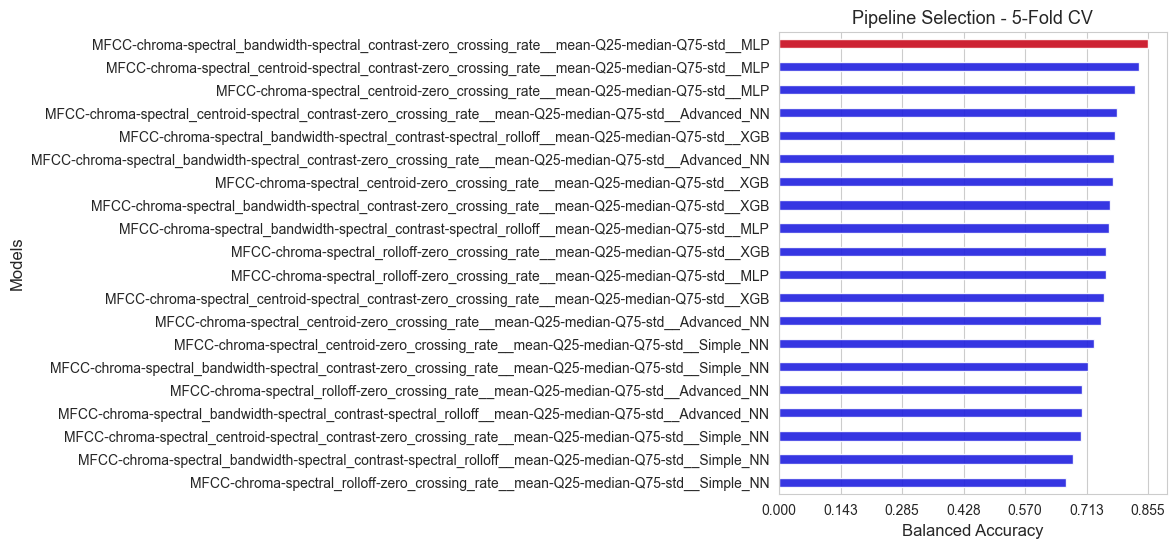

The best pipeline according to the inner evaluation is: MFCC-chroma-spectral_bandwidth-spectral_contrast-zero_crossing_rate__mean-Q25-median-Q75-std__MLP
Balanced accuracy of the best pipeline:  0.855

 Best feature extraction method:  MFCC-chroma-spectral_bandwidth-spectral_contrast-zero_crossing_rate 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  MLP

The best model hyper-parameters are:  {'learning_rate_init': 0.0007230035617449583, 'alpha': 0.0015684955983016854, 'activation': 'logistic', 'hidden_layer_sizes': 300, 'max_iter': 300}


In [5]:
fig, axes = plt.subplots(figsize=(5,6))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Pipeline Selection - 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline according to the inner evaluation is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)

print('\nThe best model hyper-parameters are: ', best_params_flatten[best_pipeline])

As we can see we have found a better pipeline that in the previous rounds, so we have improved the previous results.

This evaluation tell us that Multi Layer Perceptron seems to work well for our prediction purposes.